## DSAN 5650 HW2B: Multilevel Regression with PyMC (Modeling Languages II)

**Assignment Corrections (Run Following Cell to Fetch)**

In [8]:
import corrections
corrections.fetch("HW2B")

**DSAN5650 HW2B Corrections**

None so far!


Last fetched: 2025-07-02 18:02:46 EDT

**Assignment Submission Button (Coming Soon...)**

## [Part 3] Two-Level (Country-Individual) Multilevel Regression

This is it, the moment you've all been waiting for! Now that you've gone through the tutorial in Part 1, and the single-level regressions in Part 2, in this part you'll "weave together" what you've learned to estimate a **multilevel model** incorporating both **country-level** and **individual-level** information!<sup>[1]</sup>

Specifically, like you saw with the **Radon** example we went over in Week 5, our ultimate goal is to be able to **adaptively pool** individual-level information across countries. In other words, we'd like to model the relationship between `antiauth` and `china` for an arbitrarily-chosen individual $i$ within country $j[i]$ as a **country-size-aware balance** between two different "naïve" estimates of this effect:

*   (a) The **full-pooling** estimate of the relationship between `antiauth` (`aa`) and `china` (`ch`) across all individuals in the dataset, **ignoring their countries** of residence (here $\overline{\texttt{aa}}$ denotes the overall mean of `antiauth` across all individuals in the dataset):

    $$
    \texttt{ch}_i =
    \underbrace{\alpha}_{\mathclap{
    \substack{
        \text{Expected }\texttt{ch}_i \\[0.2em]
        \text{ if }\texttt{aa}_i = \overline{\texttt{aa}}
    }
    }}
    +
    \overbrace{\beta}^{\mathclap{
    \substack{
        \text{Expected }\Delta\texttt{ch}_i\text{ per } \\[0.2em]
        \Delta\texttt{aa}_i\text{ away from }\overline{\texttt{aa}}
    }
    }}
    \cdot \left(\texttt{aa}_i - \overline{\texttt{aa}}\right)
    $$
    
* (b) The **no-pooling** estimate of the relationship between `antiauth` and `china` among **only** individuals **within this single country $j$**:

    $$
    \texttt{ch}_i = \underbrace{\alpha_{j[i]}}_{\mathclap{
    \substack{
        \text{Expected }\texttt{ch}_i \\[0.2em]
        \text{ if }\texttt{aa}_i = \overline{\texttt{aa}}_{j[i]}
    }
    }}
    +
    \overbrace{\beta_{j[i]}}^{\mathclap{
    \substack{
        \text{Expected }\Delta\texttt{ch}_i\text{ per } \\[0.2em]
        \Delta\texttt{aa}_i\text{ away from }\overline{\texttt{aa}}_{j[i]}
    }
    }}
    \cdot (\texttt{aa}_i - \overline{aa}_{j[i]})
    $$

---

<small>

1. Incorporating political party, to form a 3-level model, is a bonus problem you can do if you'd like -- once you understand how to write 2-level models in the **modeling language** used by PyMC, you can easily modify your code to handle 3-level, 4-level, $n$-level models as needed! 😉

</small>

### The Full-Pooling Estimate

It turns out that you secretly **already derived an estimate of the full-pooling estimate (a)** -- congratulations! When you converted the `lm()`-based individual-level regression to an `ulam()`-estimated PGM in Part 2, estimating the effect of `antiauth` on `china` without regard for `country_name`, the slope and intercept parameters you learned were precisely the full-pooling estimate! Here, in Part 3.1, we provide the code for the same model re-written in PyMC, so you can see the similarities and differences with how you wrote it for `ulam()` estimation. (Then in Part 3.2, just so you have more than one example to draw from, we also provide re-written PyMC code for the country-level regression).

### The No-Pooling Estimate

Now, to derive the **no-pooling estimate (b)**, where each country $j$ has its own country-specific intercept $\alpha_j$ and country-specific slope $\beta_j$, your instinct may be to run and estimate a bunch of individual regressions via `lm()`. But... stop! This is the [Saying *"Can I have a hamburger?"* 40 times] model of computational social science, not the learning-a-language model! By learning the language of PyMC, you can intead modify the statement to e.g. *"Can I have one hamburger per country?"*, or *"Can I have one hamburger per political party?"*, or *"Can I have one hamburger for high-income individuals and another for low-income individuals?"*<sup>[1]</sup>

In Part 3.3 below, we also provide PyMC code for a no-pooling estimator, with the goal being that you can see the forest for the trees: that you can **combine** the full-pooling PyMC model given in Part 3.1 with the no-pooling PyMC model given in Part 3.3 to derive an adaptive-pooling model in Part 3.4!

---

<small>

1. *...The hamburger is an estimated regression in this terrible metaphor I'm trapped in, folks. Quite a pickle. The bunintended consequence of my cheesy choice of phrase in lecture. But lettuce move on to the next section. Wendy's Baconator*

</small>

### The Adaptive-Pooling Estimate

As shown in class with the Radon example, the **adaptive pooling** approach will strike a balance between No-Pooling and Full-Pooling, by:

* Starting with the No-Pooling estimate as a **prior** for a given country $j$, then
* Moving towards the Full-Pooling estimate as more and more data is observed for individuals in country $j$

This means, in particular, that your model's country-$j$-specific regression line will (by construction) lie somewhere **between** the no-pooling regression line from Part 2 and the regression line you would obtain by throwing away all observations besides those from country $j$. Countries with more observations will have final adaptively-pooled regression lines closer to that country's $j$-only **no-pooling** estimate, while countries with fewer observations will have lines closer to the overall **full-pooling** regression line.

With all that said, run the code cells in Parts 3.1 and 3.2 to see how the Stan models you wrote in HW2A can be converted to PyMC, run the code cells in Part 3.3 to see how a PyMC model can be written from scratch for the no-pooling estimate, then write your own implementation of adaptive pooling in Part 3.4!

In [9]:
%config IPCompleter.use_jedi = False

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import arviz as az
az.style.use("arviz-darkgrid")
import pymc as pm
import xarray as xr

In [4]:
valid_df = pd.read_csv("https://jpj.georgetown.domains/dsan5650-data/ab_valid.csv")

In [12]:
country_counts_dict = valid_df['country_name'].value_counts().to_dict()
print(country_counts_dict)

{'Kenya': 2037, 'Ghana': 2035, 'Ethiopia': 2003, 'Uganda': 1772, 'Tanzania': 1562, 'Congo-Brazzaville': 1180, 'Gabon': 1176, 'Cameroon': 1145, 'Liberia': 1139, 'Benin': 1124, 'Guinea': 1117, 'Mauritania': 1115, "Côte d'Ivoire": 1091, 'Burkina Faso': 1087, 'Nigeria': 1061, 'Morocco': 1037, 'Senegal': 1035, 'Cabo Verde': 1017, 'Mali': 1001, 'Namibia': 998, 'Eswatini': 967, 'South Africa': 951, 'São Tomé and Príncipe': 934, 'Niger': 929, 'Togo': 922, 'Madagascar': 920, 'Lesotho': 919, 'Mozambique': 908, 'Tunisia': 886, 'Gambia': 847, 'Sierra Leone': 844, 'Mauritius': 826, 'Zambia': 763, 'Angola': 742, 'Zimbabwe': 720, 'Malawi': 598, 'Botswana': 557, 'Seychelles': 463}


In [13]:
def attach_label(country_name):
    country_count = country_counts_dict[country_name]
    return f'{country_name} (N = {country_count})'
valid_df['country_label'] = valid_df['country_name'].apply(attach_label)
valid_df

,id,country_name,china,usa,accountable,gov_is_employee,follow_own_ideas,party_close,party_vote,valid_china,...,trade_china,trade_usa,party_name,party_abbr,url,ideology_full_str,ideology_str,ideology_pos_str,valid_party,country_label
0,ANG0001,Angola,4,4,2,3,3,9997,9997,True,...,20.889409,2.594860,NaN,NaN,NaN,NaN,NaN,NaN,False,Angola (N = 742)
1,ANG0003,Angola,1,1,1,4,3,1752,9999,True,...,20.889409,2.594860,NaN,NaN,NaN,NaN,NaN,NaN,False,Angola (N = 742)
2,ANG0006,Angola,2,4,3,4,2,9997,1751,True,...,20.889409,2.594860,UNITA - Adalberto da Costa Junior,UNITA,https://en.wikipedia.org/wiki/UNITA,Big tent;Conservatism;Anti-communism,Conservatism,Center-Right to Right,True,Angola (N = 742)
3,ANG0007,Angola,4,4,1,3,4,9997,1751,True,...,20.889409,2.594860,UNITA - Adalberto da Costa Junior,UNITA,https://en.wikipedia.org/wiki/UNITA,Big tent;Conservatism;Anti-communism,Conservatism,Center-Right to Right,True,Angola (N = 742)
4,ANG0008,Angola,5,5,2,4,1,9997,1750,True,...,20.889409,2.594860,MPLA/ João Lourenço,MPLA,https://en.wikipedia.org/wiki/MPLA,Angolan nationalism;Social democracy;Democrati...,Democratic socialism,Center-Left to Left,True,Angola (N = 742)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40423,ZIM1195,Zimbabwe,1,9,4,4,1,860,860,True,...,3.825806,0.113309,Citizens Coalition for Change,CCC,https://en.wikipedia.org/wiki/Citizens_Coaliti...,Social democracy;Christian democracy;Liberal d...,Social democracy,Center-Left,True,Zimbabwe (N = 720)
40424,ZIM1196,Zimbabwe,1,9,2,3,1,860,860,True,...,3.825806,0.113309,Citizens Coalition for Change,CCC,https://en.wikipedia.org/wiki/Citizens_Coaliti...,Social democracy;Christian democracy;Liberal d...,Social democracy,Center-Left,True,Zimbabwe (N = 720)
40425,ZIM1197,Zimbabwe,3,9,4,4,1,9998,9999,True,...,3.825806,0.113309,NaN,NaN,NaN,NaN,NaN,NaN,False,Zimbabwe (N = 720)
40426,ZIM1199,Zimbabwe,1,9,4,4,2,9997,9998,True,...,3.825806,0.113309,NaN,NaN,NaN,NaN,NaN,NaN,False,Zimbabwe (N = 720)


## [Part 3.1] Individual-Level Regression Redone in PyMC

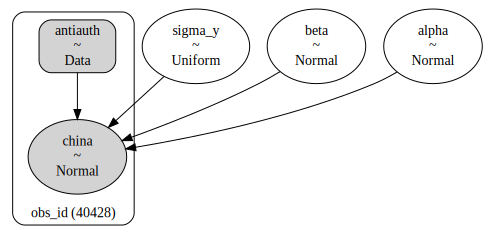

In [14]:
antiauth_vals = valid_df['antiauth'].values
aa_mean = np.mean(antiauth_vals)
china_vals = valid_df['china'].values
china_mean = np.mean(china_vals)
with pm.Model() as indiv_model:
    antiauth = pm.Data("antiauth", antiauth_vals, dims="obs_id")

    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta = pm.Normal("beta", mu=0, sigma=5)
    sigma_y = pm.Uniform("sigma_y", 0, 5)

    mu_y = alpha + beta * antiauth

    china = pm.Normal("china", mu=mu_y, sigma=sigma_y, observed=china_vals, dims="obs_id")
pm.model_to_graphviz(indiv_model)

In [16]:
with indiv_model:
    indiv_trace = pm.sample(random_seed=5650)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [17]:
az.summary(indiv_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.75,0.03,3.69,3.80,0.0,0.0,1547.97,1733.39,1.0
beta,-0.08,0.01,-0.09,-0.06,0.0,0.0,1521.78,1838.44,1.0
sigma_y,1.37,0.00,1.37,1.38,0.0,0.0,1526.46,1540.38,1.0


In [18]:
indiv_post_mean = indiv_trace.posterior.mean(dim=("chain", "draw"))
indiv_post_mean

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    alpha    float64 8B 3.748
    beta     float64 8B -0.07585
    sigma_y  float64 8B 1.375

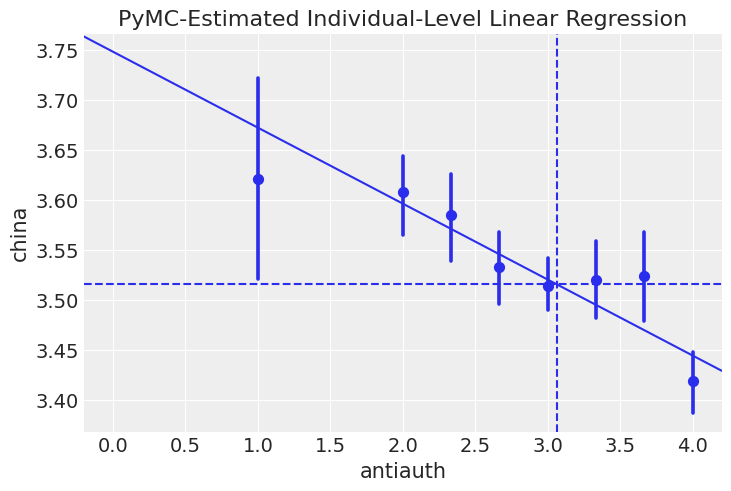

In [20]:
qvals = np.linspace(0, 1, num=20)
qtiles = np.quantile(valid_df['antiauth'], q=qvals)
ax = sns.regplot(
    data=valid_df, x="antiauth", y="china", x_bins=qtiles, truncate=False,
    x_ci='ci',
    fit_reg=False,
    # ci=None, x_ci='ci'
);
ax.axvline(x=aa_mean, ls="dashed");
ax.axhline(y=china_mean, ls="dashed");
ax.axline(xy1=(0, indiv_post_mean["alpha"]), slope=indiv_post_mean["beta"]);
plt.title("PyMC-Estimated Individual-Level Linear Regression");
plt.show()

#plt.scatter(valid_df.antiauth, valid_df.china)
#xvals = xr.DataArray(np.linspace(-0.2, 1.2))
#plt.plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--");

## [Part 3.2] Country-Level Regression Re-Written in PyMC

0.9250165178695196


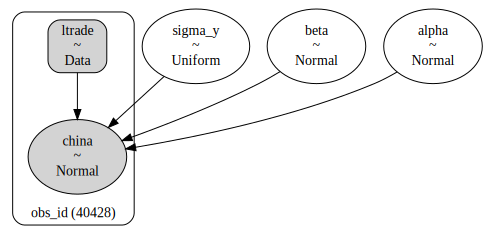

In [21]:
valid_df['ltrade_china'] = valid_df['trade_china'].apply(np.log)

ltrade_vals = valid_df['ltrade_china'].values
ltrade_mean = np.mean(ltrade_vals)
print(ltrade_mean)
china_vals = valid_df['china'].values
china_mean = np.mean(china_vals)
with pm.Model() as country_model:
    ltrade = pm.Data("ltrade", ltrade_vals, dims="obs_id")

    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta = pm.Normal("beta", mu=0, sigma=5)
    sigma_y = pm.Uniform("sigma_y", 0, 5)

    mu_y = alpha + beta * ltrade

    china = pm.Normal("china", mu=mu_y, sigma=sigma_y, observed=china_vals, dims="obs_id")
pm.model_to_graphviz(country_model)

In [22]:
with country_model:
    country_trace = pm.sample(random_seed=5650)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [23]:
az.summary(country_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.60,0.01,3.59,3.61,0.0,0.0,3497.80,2938.58,1.0
beta,-0.09,0.00,-0.10,-0.08,0.0,0.0,3362.19,3322.79,1.0
sigma_y,1.37,0.00,1.36,1.38,0.0,0.0,5063.39,3249.43,1.0


In [1]:
country_post_mean = country_trace.posterior.mean(dim=("chain", "draw"))

NameError: name 'country_trace' is not defined

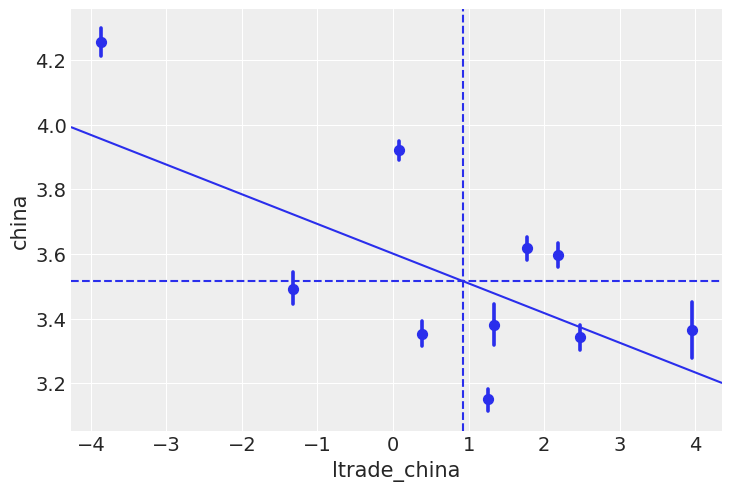

In [26]:
qvals = np.linspace(0, 1, num=10)
qtiles = np.quantile(valid_df['ltrade_china'], q=qvals)
ax = sns.regplot(
    data=valid_df, x="ltrade_china", y="china", x_bins=qtiles, truncate=False,
    x_ci='ci',
    fit_reg=False
    # ci=None, x_ci='ci'
);
ax.axvline(x=ltrade_mean, ls="dashed");
ax.axhline(y=china_mean, ls="dashed");
ax.axline(xy1=(0, country_post_mean["alpha"]), slope=country_post_mean["beta"]);

#plt.scatter(valid_df.antiauth, valid_df.china)
#xvals = xr.DataArray(np.linspace(-0.2, 1.2))
#plt.plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--");

## [Part 3.3] The No-Pooling Multilevel Model

Recall the difference between the **no-pooling** and **full-pooling** estimates: though we already estimated the **full-pooling** model above (in Part 3.1), here we should write the **no-pooling** model in such a way that we can easily take it and make just a few modifications to arrive at the **adaptive-pooling** model in Part 3.4!

In [27]:
country_idx, country_names = valid_df['country_name'].factorize()
print(country_idx)
print(country_names)

[ 0  0  0 ... 37 37 37]
Index(['Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Cabo Verde', 'Cameroon',
       'Congo-Brazzaville', 'Côte d'Ivoire', 'Eswatini', 'Ethiopia', 'Gabon',
       'Gambia', 'Ghana', 'Guinea', 'Kenya', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'São Tomé and Príncipe',
       'Senegal', 'Seychelles', 'Sierra Leone', 'South Africa', 'Tanzania',
       'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'],
      dtype='object')


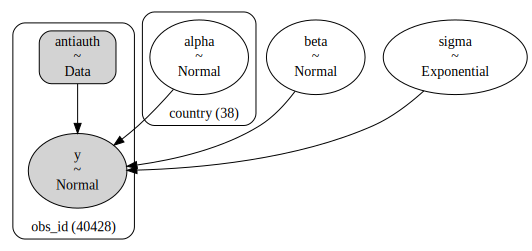

In [28]:
antiauth_vals = valid_df['antiauth'].values
aa_mean = np.mean(antiauth_vals)
china_vals = valid_df['china'].values
china_mean = np.mean(china_vals)

coords = {"country": country_names}
with pm.Model(coords=coords) as np_model:
    antiauth = pm.Data("antiauth", antiauth_vals, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="country")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[country_idx] + beta * antiauth

    china = pm.Normal("y", theta, sigma=sigma, observed=china_vals, dims="obs_id")
pm.model_to_graphviz(np_model)

In [29]:
with np_model:
    np_trace = pm.sample(random_seed=5650)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


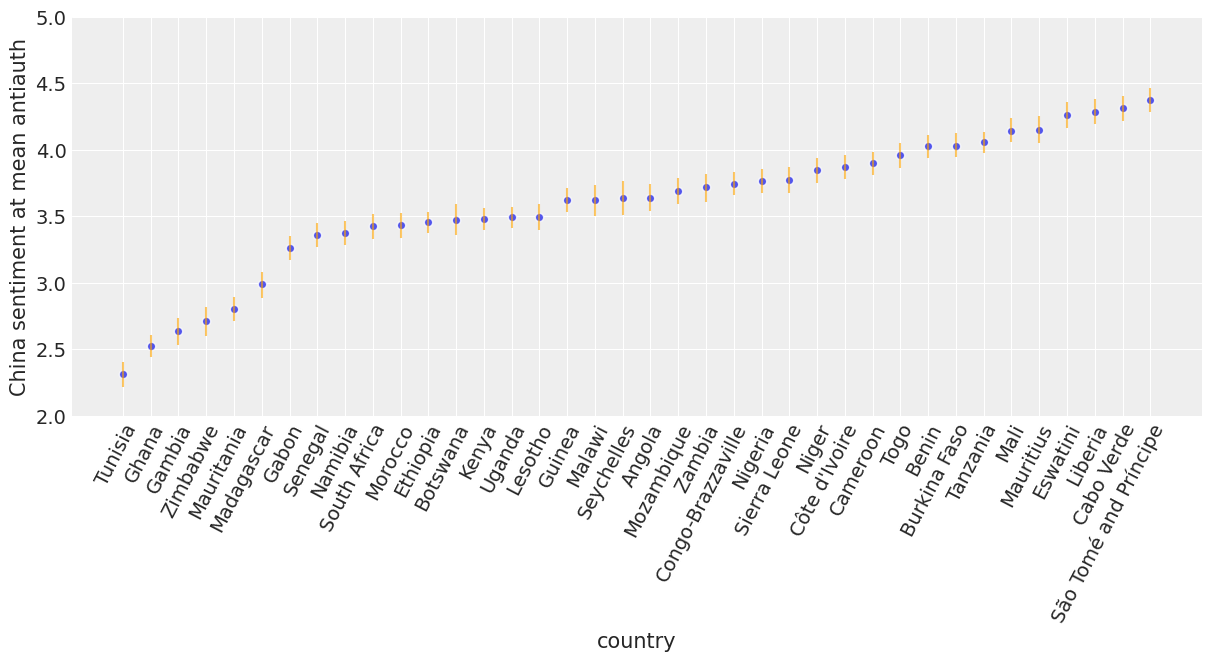

In [30]:
np_means = np_trace.posterior.mean(dim=("chain", "draw"))
np_hdi = az.hdi(np_trace)

np_means_iter = np_means.sortby("alpha")
np_hdi_iter = np_hdi.sortby(np_means_iter.alpha)

_, ax = plt.subplots(figsize=(12, 6.5))
xticks = np.arange(0, len(country_names), 1)
np_means_iter.plot.scatter(x="country", y="alpha", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(country_names.size),
    np_hdi_iter.alpha.sel(hdi="lower"),
    np_hdi_iter.alpha.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="China sentiment at mean antiauth", ylim=(2, 5))
ax.set_xticks(xticks)
ax.set_xticklabels(np_means_iter.country.values[xticks])
#ax.tick_params(rotation=45, );
plt.setp(ax.get_xticklabels(), rotation=62.5, ha="right", rotation_mode="anchor");

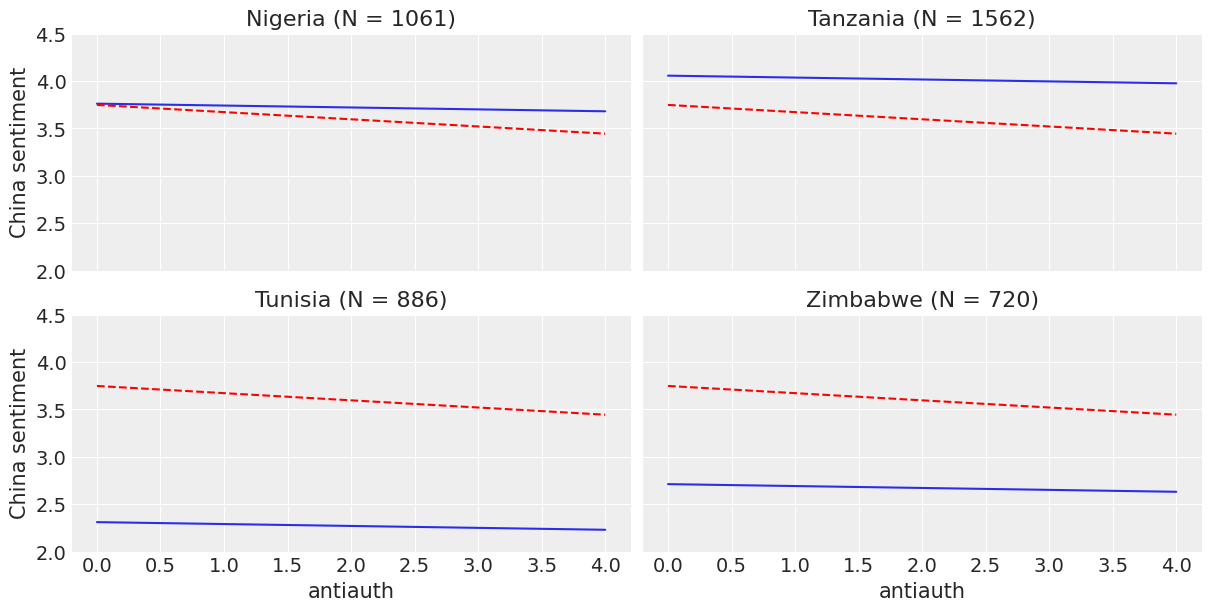

In [31]:
sample_countries = (
    "Nigeria",
    "Tanzania",
    "Tunisia",
    "Zimbabwe",
)

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = np_means["beta"]
for i, c in enumerate(sample_countries):
    y = valid_df.china[valid_df.country_name == c]
    x = valid_df.antiauth[valid_df.country_name == c]
    clabel = valid_df.country_label[valid_df.country_name == c].iloc[0]
    # axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = np_means["alpha"].sel(country=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(0, 4))
    axes[i].plot(xvals, m * xvals + b)
    axes[i].plot(xvals, indiv_post_mean["beta"] * xvals + indiv_post_mean["alpha"], "r--")
    # axes[i].set_xticks([0, 1])
    # axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(2, 4.5)
    axes[i].set_title(clabel)
    if not i % 2: axes[i].set_ylabel("China sentiment")
    if i >= 2: axes[i].set_xlabel("antiauth")

...But wait, what's this?!?

<center>
<img src="https://github.com/jpowerj/dsan-content/blob/main/2025-sum-dsan5650/hw2/AB_Pikachu.png?raw=true" width="40%"></img>
</center>

A harried Research Assistant rushes into the room and drops a... some sort of physical representation of data onto your desk (idk, a flash drive, or whatever you zoomers use nowadays). The out-of-breath Research Minion (RM), as you call this grotesque yellow creature with overalls and a single goggled eye, carefully avoids direct eye contact but slowly builds up the courage to speak to you.

> RM: *"My liege, my DSAN 5650 Data Analyst, your honor, your majesty, I'm so sorry to bother you, but we just finished collecting data for two new countries in our sample! Just in time for your HW2B Part 3.3!"*
>
> You: *"But... I already started HW2B Part 3.3"*
>
> RM: *"..."*
>
> You: *"..."*
>
> RM: *"That's right, two new countries! One is called **Zudan**, and the other is called **Zudania**, and neither one has anything to do with the strange omission of Sudan from the datset you've been using!"*
>
> You: *"Ok but*

Your task now is to **re-estimate** the above model using this new data, which we load for you at the beginning of the following cell:

In [5]:
# @title Q3.3-response
new_df = pd.read_csv("https://jpj.georgetown.domains/dsan5650-data/ab_zudania.csv")
new_country_counts_dict = new_df['country_name'].value_counts().to_dict()
def attach_new_label(country_name):
    country_count = new_country_counts_dict[country_name]
    return f'{country_name} (N = {country_count})'
new_df['country_label'] = new_df['country_name'].apply(attach_new_label)
new_country_idx, new_country_names = new_df['country_name'].factorize()
print(new_country_idx)
print(new_country_names)

[ 0  0  0 ... 39 39 39]
Index(['Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Cabo Verde', 'Cameroon',
       'Congo-Brazzaville', 'Côte d'Ivoire', 'Eswatini', 'Ethiopia', 'Gabon',
       'Gambia', 'Ghana', 'Guinea', 'Kenya', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'São Tomé and Príncipe',
       'Senegal', 'Seychelles', 'Sierra Leone', 'South Africa', 'Tanzania',
       'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe', 'Zudan', 'Zudania'],
      dtype='object')


/var/folders/cr/df6gvtx90rz5bg2m0clb1gym0000gn/T/ipykernel_85896/591413101.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv("https://jpj.georgetown.domains/dsan5650-data/ab_zudania.csv")


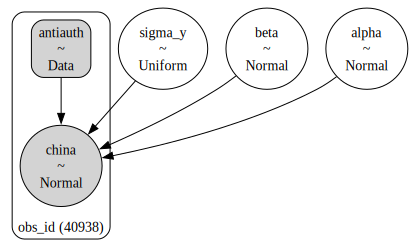

In [6]:
new_antiauth_vals = new_df['antiauth'].values
new_aa_mean = np.mean(new_antiauth_vals)
new_china_vals = new_df['china'].values
new_china_mean = np.mean(new_china_vals)

with pm.Model() as new_indiv_model:
    antiauth = pm.Data("antiauth", new_antiauth_vals, dims="obs_id")

    alpha = pm.Normal("alpha", mu=3, sigma=3)
    beta = pm.Normal("beta", mu=0, sigma=5)
    sigma_y = pm.Uniform("sigma_y", 0, 5)

    mu_y = alpha + beta * (antiauth - new_aa_mean)

    china = pm.Normal("china", mu=mu_y, sigma=sigma_y, observed=new_china_vals, dims="obs_id")
pm.model_to_graphviz(new_indiv_model)

In [34]:
with new_indiv_model:
    new_indiv_trace = pm.sample(random_seed=5650)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [35]:
new_indiv_post_mean = new_indiv_trace.posterior.mean(dim=("chain", "draw"))
new_indiv_post_mean

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    alpha    float64 8B 3.492
    beta     float64 8B -0.0597
    sigma_y  float64 8B 1.384

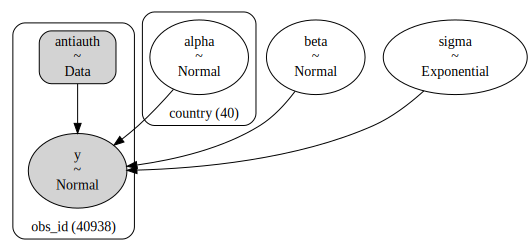

In [36]:
coords = {"country": new_country_names}
with pm.Model(coords=coords) as new_np_model:
    antiauth = pm.Data("antiauth", new_antiauth_vals, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="country")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[new_country_idx] + beta * antiauth

    china = pm.Normal("y", theta, sigma=sigma, observed=new_china_vals, dims="obs_id")
pm.model_to_graphviz(new_np_model)

In [37]:
with new_np_model:
    new_np_trace = pm.sample(random_seed=5650)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


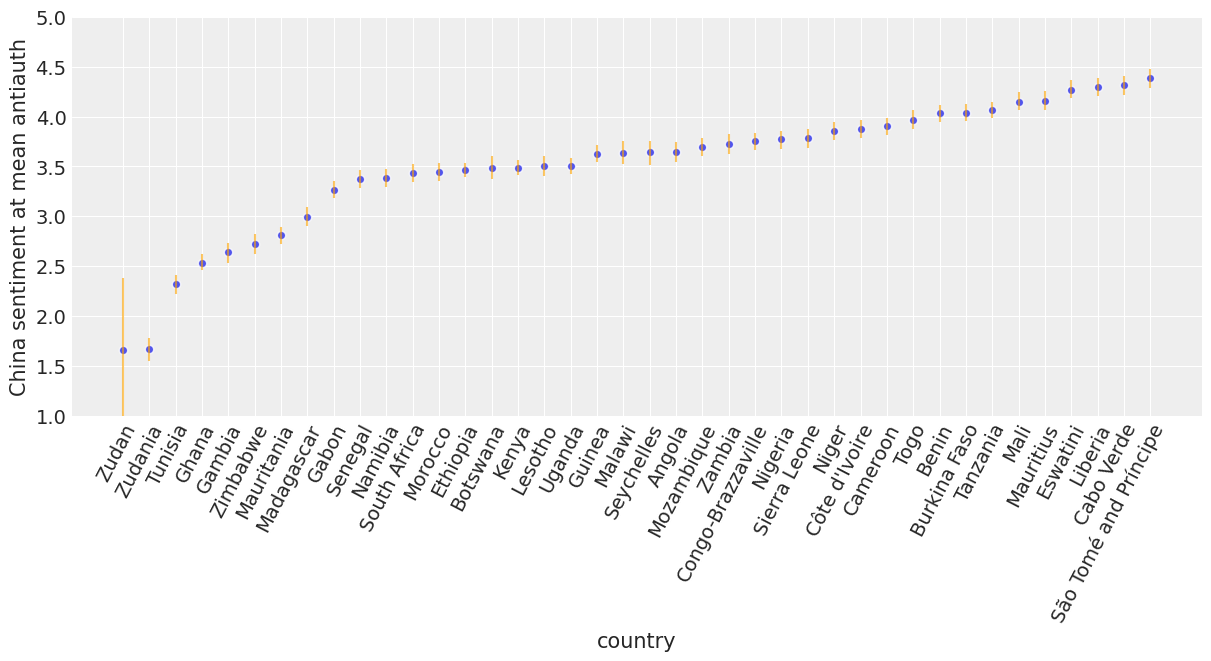

In [38]:
new_np_post_means = new_np_trace.posterior.mean(dim=("chain", "draw"))
new_np_hdi = az.hdi(new_np_trace)

new_np_post_means_iter = new_np_post_means.sortby("alpha")
new_np_hdi_iter = new_np_hdi.sortby(new_np_post_means_iter.alpha)

_, ax = plt.subplots(figsize=(12, 6.5))
xticks = np.arange(0, len(new_country_names), 1)
new_np_post_means_iter.plot.scatter(x="country", y="alpha", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(new_country_names.size),
    new_np_hdi_iter.alpha.sel(hdi="lower"),
    new_np_hdi_iter.alpha.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="China sentiment at mean antiauth", ylim=(1, 5))
ax.set_xticks(xticks)
ax.set_xticklabels(new_np_post_means_iter.country.values[xticks])
#ax.tick_params(rotation=45, );
plt.setp(ax.get_xticklabels(), rotation=62.5, ha="right", rotation_mode="anchor");

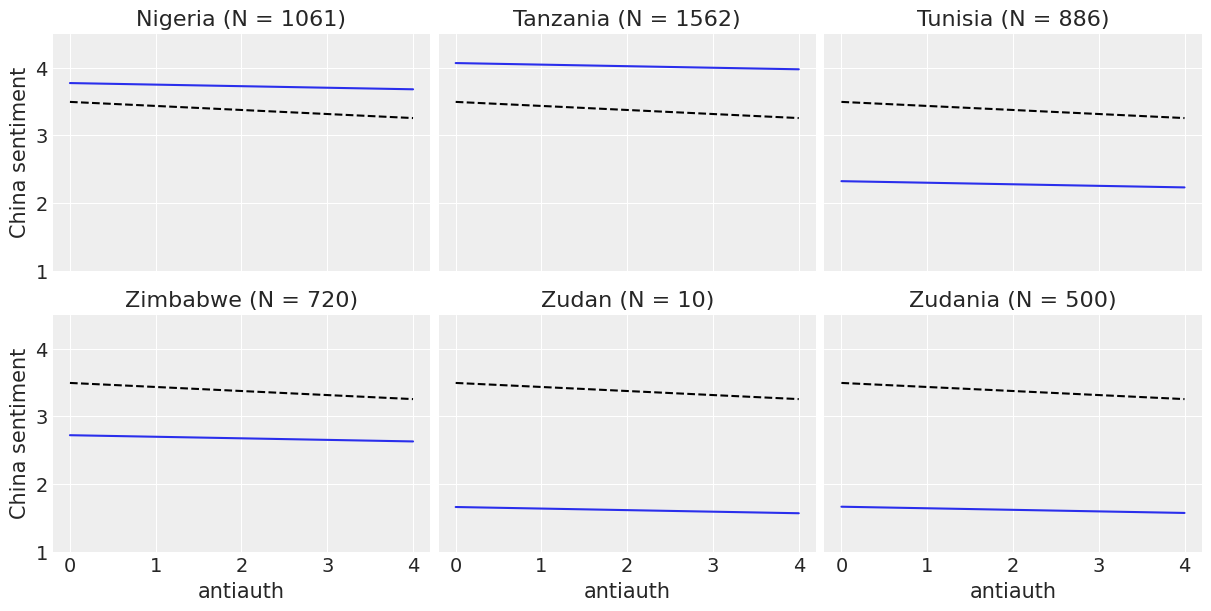

In [41]:
new_sample_countries = (
    "Nigeria",
    "Tanzania",
    "Tunisia",
    "Zimbabwe",
    "Zudan",
    "Zudania",
)

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = new_np_post_means["beta"]
for i, c in enumerate(new_sample_countries):
    y = new_df.china[new_df.country_name == c]
    x = new_df.antiauth[new_df.country_name == c]
    clabel = new_df.country_label[new_df.country_name == c].iloc[0]
    # axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = new_np_post_means["alpha"].sel(country=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(0, 4))
    axes[i].plot(xvals, m * xvals + b)
    axes[i].plot(xvals, new_indiv_post_mean["beta"] * xvals + new_indiv_post_mean["alpha"], "k--")
    # axes[i].set_xticks([0, 1])
    # axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(1, 4.5)
    axes[i].set_title(clabel)
    if not i % 3: axes[i].set_ylabel("China sentiment")
    if i >= 3: axes[i].set_xlabel("antiauth")

## [Part 3.4] Multilevel Model with Adaptive Pooling

Now's your time to shine! Complete the adaptive-pooling model started for you in the following code cell. If the model is written out without any syntax errors, the `pm.model_to_graphviz()` call at the end will display your model in PGM form, so you can check that it matches what you're expecting.

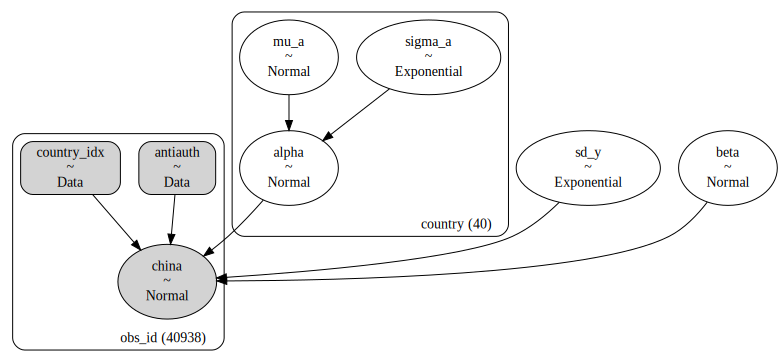

In [47]:
# @title Q3.4a-response
with pm.Model(coords=coords) as adaptive_model:
    antiauth = pm.Data("antiauth", new_antiauth_vals, dims="obs_id")
    country_idx = pm.Data("country_idx", new_country_idx, dims="obs_id")

    # Your code here: priors for country-by-country intercepts
    mu_a = pm.Normal("mu_a", 0, sigma=10, dims="country") # Replace with prior distribution for mean of intercept
    sigma_a = pm.Exponential("sigma_a", 1, dims="country") # Replace with prior distribution for sd of intercept

    # Your code here: country-specific intercepts
    alpha = pm.Normal("alpha", mu_a, sigma=sigma_a, dims="country") # Replace with draw from distribution
    
    # Your code here: one common slope across countries
    beta = pm.Normal("beta", 0, sigma=10) # Replace with draw from distribution

    # Prior for the range of y values around mu_y
    sd_y = pm.Exponential("sd_y", 1) # Replace with prior distribution for sd of y
    
    # Your code here: compute mu_y, the center of the distribution from which
    # the ultimate Y value will be drawn in the last line of the model below
    mu_y = alpha[country_idx] + beta * antiauth # Replace with (deterministic) computation of mu_y

    # The final distribution of the dependent variable Y = china
    china = pm.Normal("china", mu=mu_y, sigma=sd_y, observed=new_china_vals, dims="obs_id")
pm.model_to_graphviz(adaptive_model)

Once your model is set up correctly, run the following code cell to estimate the model's parameters via the MCMC algorithm:

In [48]:
# @title Q3.4b-response
with adaptive_model:
    adaptive_trace = pm.sample(random_seed=5650)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, alpha, beta, sd_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 206 seconds.
There were 1238 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


This is the final step! If your model in the cell titled `Q3.4a-response` is correct, the following code will plot the **no-pooling**, **full-pooling**, and **adaptive-pooling** estimates of the relationship between `antiauth` and `china` for each of our six "puzzle countries"!

For sanity purposes, the following image is a screenshot from my implementation -- yours should look roughly similar, though it doesn't need to be identical (since "stricter" prior choices for $\sigma_\alpha$ will "pull" the adaptive estimate closer to the full-pooling line, while less-strict choices will pull it closer to the no-pooling line, and the choice is up to you!)

<center>
<figure>
<img src="https://github.com/jpowerj/dsan-content/blob/main/2025-sum-dsan5650/hw2/adaptive.png?raw=true" width="80%"></img>
<figcaption><i>The general form of the result you should get from running the following code cell -- the adaptive estimate for Zudan should be somewhere right in between the no-pooling and full-pooling lines, whereas the adaptive estimate for Zudania should be almost indistinguishable from its no-pooling estimate!</i></figcaption>
</figure>
</center>

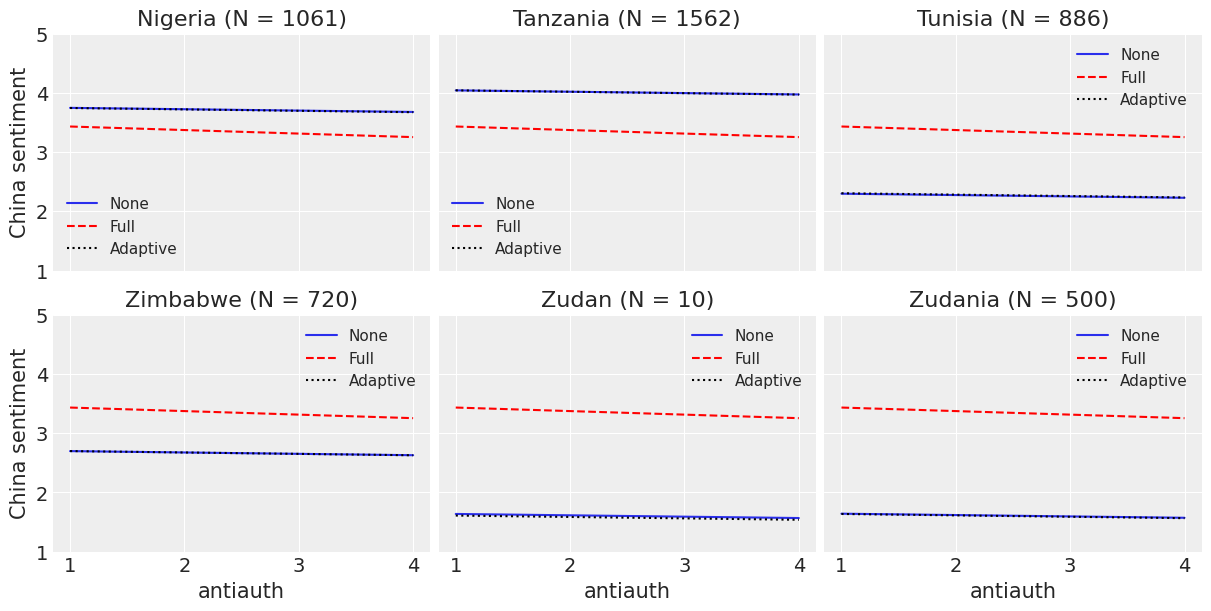

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = new_np_post_means["beta"]
for i, c in enumerate(new_sample_countries):
    y = new_df.china[new_df.country_name == c]
    x = new_df.antiauth[new_df.country_name == c]
    clabel = new_df.country_label[new_df.country_name == c].iloc[0]
    # axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = new_np_post_means["alpha"].sel(country=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(1, 4))
    axes[i].plot(xvals, m.values * xvals + b.values)
    axes[i].plot(xvals, new_indiv_post_mean["beta"] * xvals + new_indiv_post_mean["alpha"], "r--")

    # varying_intercept_trace.posterior.sel(country=c).beta
    adaptive_post = adaptive_trace.posterior.sel(country=c).mean(dim=("chain", "draw"))
    theta = adaptive_post.alpha.values + adaptive_post.beta.values * xvals
    axes[i].plot(xvals, theta, "k:")
    #axes[i].set_xticks([0, 1])
    #axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(1, 5)
    axes[i].set_title(clabel)
    axes[i].legend(['None','Full','Adaptive'], prop={'size': 11})
    if not i % 3: axes[i].set_ylabel("China sentiment")
    if i >= 3: axes[i].set_xlabel("antiauth")